##LSTM w/Garch

In [ ]:
!pip install keras_tuner
!wget -q https://raw.githubusercontent.com/Undeavor/PE28/main/CREDITAGRICOLESA_2025-10-15.txt -O CA2.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas_datareader import data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import *
from tensorflow.keras.utils import plot_model

In [ ]:
sp = pd.read_csv("/content/CA2.txt", sep="\t",usecols=["Date", "ouv", "haut", "bas", "Close", "vol", "devise"], parse_dates=["Date"], dayfirst=True )
print (sp.head())
print (sp.shape)

        Date     ouv    haut     bas   Close      vol devise
0 2005-10-17  23.078  23.172  22.899  23.040  2764750    EUR
1 2005-10-18  23.031  23.078  22.580  22.599  4425717    EUR
2 2005-10-19  22.467  22.608  22.223  22.241  4345454    EUR
3 2005-10-20  22.636  22.768  22.194  22.241  3568692    EUR
4 2005-10-21  22.091  22.420  22.091  22.138  2883072    EUR
(5119, 7)


In [ ]:
sp.Date = pd.to_datetime(sp.Date)
sp.dropna(inplace = True)
#on se limite au strict minimum de données pour l'instant : le prix de fermeture
sp.drop(columns = ["Date", "ouv", "haut", "bas", "vol", "devise"], inplace = True)
print (sp.head())
print (sp.shape)

    Close
0  23.040
1  22.599
2  22.241
3  22.241
4  22.138
(5119, 1)


    Close   returns  log_returns
0  23.040       NaN          NaN
1  22.599 -0.019141    -0.019326
2  22.241 -0.015841    -0.015968
3  22.241  0.000000     0.000000
4  22.138 -0.004631    -0.004642
(5119, 3)
    Close   returns  log_returns
1  22.599 -0.019141    -0.019326
2  22.241 -0.015841    -0.015968
3  22.241  0.000000     0.000000
4  22.138 -0.004631    -0.004642
5  22.617  0.021637     0.021406


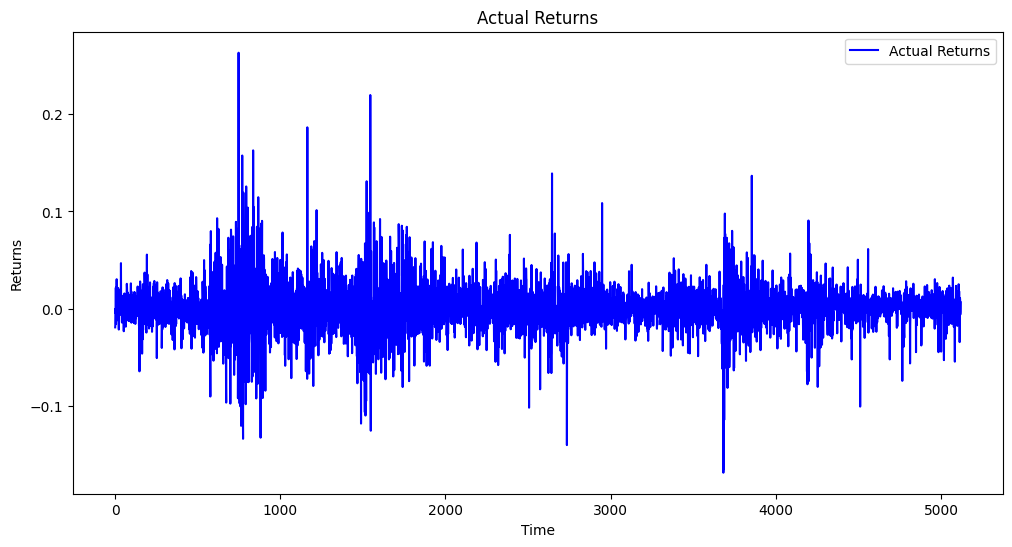

In [ ]:
sp['returns'] = sp['Close'].pct_change()
sp['log_returns'] = np.log(sp['Close'] / sp['Close'].shift(1))
sp.dropna(inplace = True)
print (sp.head())
print (sp.shape)
plt.figure(figsize=(12, 6))
plt.plot(sp.returns, label='Actual Returns', color='blue')
plt.title('Actual Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()

X_train = sp['returns']
#X = sp['log_returns'].values.reshape(-1, 1)
y_train = sp['returns']

In [ ]:
#on considère que y_true vaut l'input, ie les rendements
def nll_gaussian(y_true, y_pred):
    eps = 1e-8
    y_pred = tf.clip_by_value(y_pred, eps, 0.2)  # borne réaliste
    term1 = 0.5 * tf.math.log(y_pred)
    term2 = 0.5 * tf.square(y_true) / y_pred
    return tf.reduce_mean(term1 + term2)

In [ ]:
inputMLP = Input(shape=(1,))
x = Dense(128, activation='relu')(inputMLP)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
# Use softplus to ensure positive output for variance
output = Dense(1, name='volatility')(x)

mlp = Model(inputs=inputMLP, outputs=output)
mlp.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=nll_gaussian # ou weighted_mse_stable si tu veux pondérer
)
mlp.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ volatility (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,625 (41.50 KB)

 Trainable params: 10,625 (41.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#hist = lstm.fit(X_train, y_train,batch_size=20,epochs=32,verbose=1,validation_split=0.3,shuffle=False)
hist = mlp.fit(
    X_train, y_train,         # données d'entraînement
    batch_size=80,            # nombre d'échantillons par mise à jour des poids
    epochs=32,                # nombre de passages sur tout le dataset
    verbose=0,                # 1 = affiche la progression
    #validation_split=0.3,#sert à qqch ??
    shuffle=False             # important pour les séries temporelles
)

In [ ]:
# Prédictions sur le test set
y_pred = mlp.predict(X_train)
print (y_pred[:40])
print (y_pred.shape)
print(np.var(sp.returns, ddof=1))

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[0.6928002 ]
 [0.69285995]
 [0.6931472 ]
 [0.6930632 ]
 [0.69303584]
 [0.692861  ]
 [0.6930949 ]
 [0.69291985]
 [0.69312334]
 [0.692991  ]
 [0.69314516]
 [0.69311535]
 [0.69304484]
 [0.69307494]
 [0.6931163 ]
 [0.6930899 ]
 [0.6930979 ]
 [0.69306815]
 [0.6930372 ]
 [0.6929954 ]
 [0.6929949 ]
 [0.6930487 ]
 [0.6927596 ]
 [0.6931104 ]
 [0.6930476 ]
 [0.6930837 ]
 [0.69312507]
 [0.6930345 ]
 [0.69312614]
 [0.69314045]
 [0.69312537]
 [0.693135  ]
 [0.6930971 ]
 [0.6931048 ]
 [0.6930987 ]
 [0.6929061 ]
 [0.6930865 ]
 [0.6930333 ]
 [0.6931204 ]
 [0.69314075]]
(5118, 1)
0.0006079018207672052


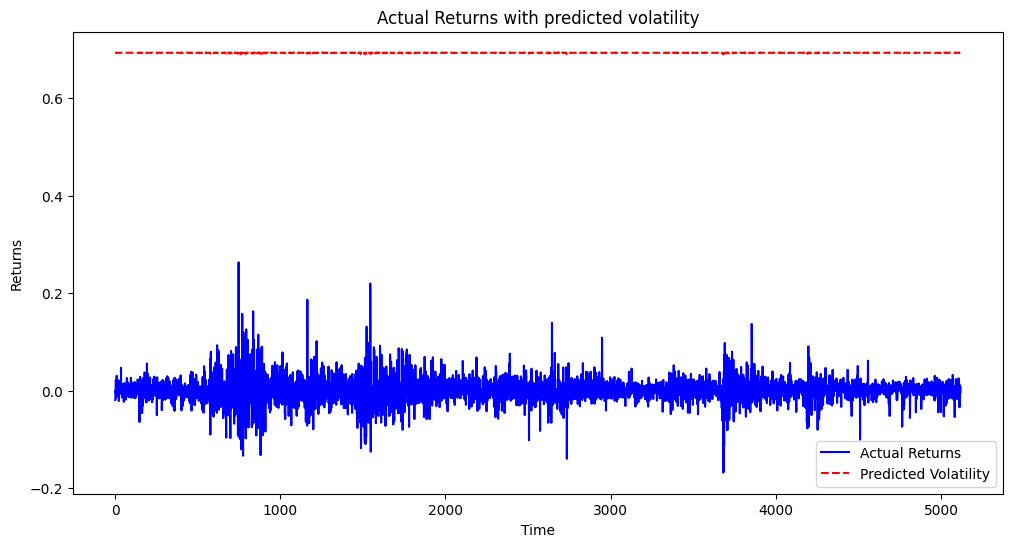

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Actual Returns', color='blue')
plt.plot(y_pred, label='Predicted Volatility', color='red', linestyle='--')
plt.title('Actual Returns with predicted volatility')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()